In [5]:
using Revise
using NonEqDigits

In [6]:
using GLMakie
using CairoMakie
using JLD2
using GraphvizDotLang: attr
using GraphvizDotLang

In [72]:
includet("../scripts/ma_colors.jl")
# single_col_width = 324 # corresponds to 3+3/8 in as state in PR guidelines
# single_col_width = 324 * 1.049868766 # corresponds to 9cm
single_col_width = 324 * 1.051437737 # corresponds to 511 pdf pt which is ~9cm
double_col_width = single_col_width*2
golden_ratio = 1.618
nothing

# Making the data

In [8]:
using DataFrames
includet("../scripts/ned_ca_s1_stats.jl")

In [9]:
function make_s1_data(L, reduced=false, rs=ca_ucodes_f1())
    numenz = ca_numenzymes.(rs)
    numacs = []
    Nac = []
    Nsingle = []
    Neq = []
    Nneq = []
    Kac = []
    Ksingle = []
    Keq = []
    Kneq = []
    for r in rs
        ma = MolAut(L, r; reduced)
        acs = attracting_components(ma.mg)
        push!(numacs, length(acs))
        
        acis_single, acis_eq, acis_neq, _, _ = classify_acs_s1_stats(ma.mg, acs)

        push!(Nac, length(acs))
        push!(Nsingle, length(acis_single))
        push!(Neq, length(acis_eq))
        push!(Nneq, length(acis_neq))
    
        Ksingle_ = 0
        for aci in acis_single
            Ksingle_ += length(acs[aci])
        end
        Keq_ = 0
        for aci in acis_eq
            Keq_ += length(acs[aci])
        end
        Kneq_ = 0
        for aci in acis_neq
            Kneq_ += length(acs[aci])
        end
        push!(Kac, sum(length, acs))
        push!(Ksingle, Ksingle_)
        push!(Keq, Keq_)
        push!(Kneq, Kneq_)
    end

    df = DataFrame(;
        rs,
        numenz,
        numacs,
        Nac,
        Nsingle,
        Neq,
        Nneq,
        Kac,
        Ksingle,
        Keq,
        Kneq
    )
    
    sp = sortperm(collect(zip(.- Nac, .- Nsingle, .- Neq, rs)))
    df = df[sp,:]
    
    metadata!(df, "L", L)
    metadata!(df, "reduced", reduced)

    df
end

make_s1_data (generic function with 3 methods)

In [10]:
using CSV
for L in [3, 4, 5, 6, 7, 8]
    CSV.write("../data/figures/numacs/data/L$(L)f.csv", make_s1_data(L))
end

┌ Warning: Note: adding edges with a zero weight to this graph type has no effect.
└ @ SimpleWeightedGraphs ~/.julia/packages/SimpleWeightedGraphs/Ab8wv/src/simpleweighteddigraph.jl:170


In [216]:
cacode_to_Ks(232)

([0 0; 0 1], [1 0; 0 0])

# Main v4

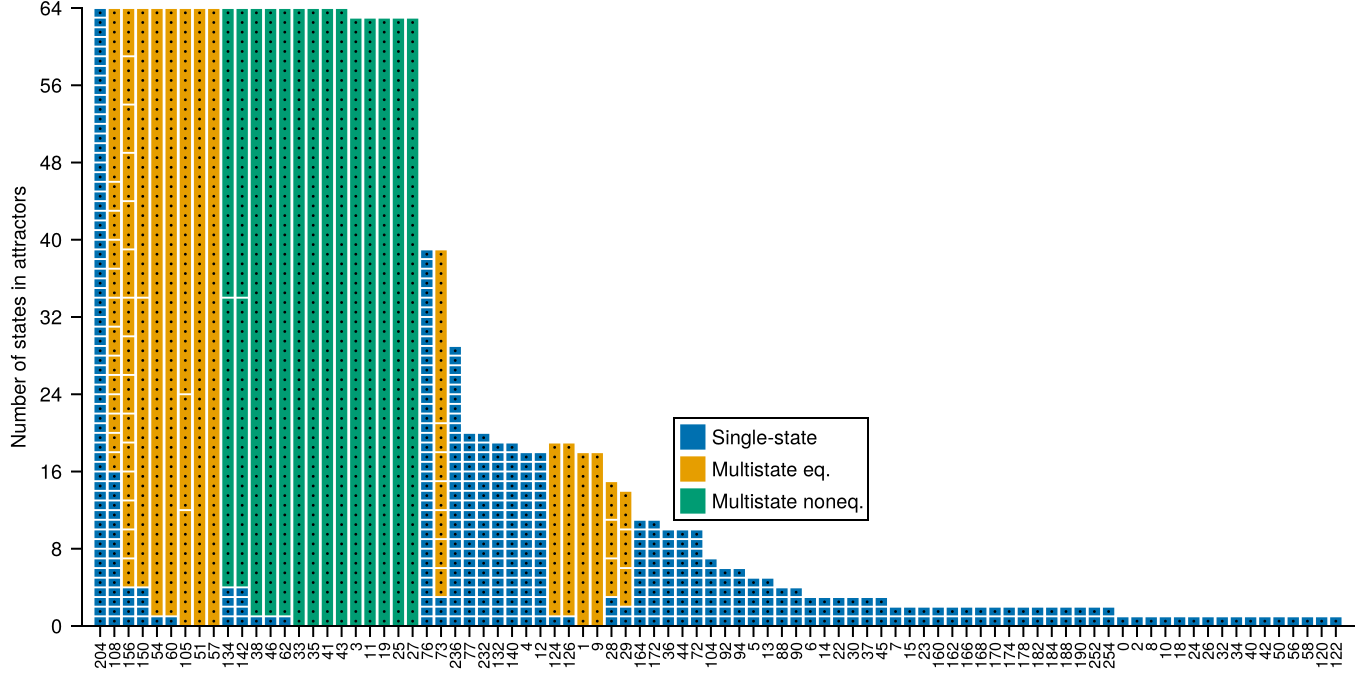

In [223]:
L = 6
reduced = false

# Get an adequately sorted list of rs
df = make_s1_data(L, reduced)
sortscore = -1000 * df.Kac - 100 * df.Ksingle - 10 * df.Keq
rs = df.rs[sortperm(sortscore)]

pos = 1:length(rs)

fig = Figure(;
    size=(double_col_width, (double_col_width/golden_ratio) * 0.8),
    fontsize=10,
    figure_padding=4.0
)

ax1 = Axis(fig[1,1];
    # title="L=$L, reduced=$reduced",
    xticks=(1:length(rs), string.(rs)),
    xticklabelsize=8.,
    xticklabelrotation=pi/2,
    # xticklabelfont=:bold,
    xgridvisible=false,
    xautolimitmargin = (0.01, 0.01),
    # xlabel="Rule",
    yticks=0:8:(2^L),
    # yticks=0:4:(2^L),
    ygridvisible=false,
    yautolimitmargin=(0., 0.),
    # yscale=log2,
    ylabel="Number of states in attractors",
)
ylims!(ax1, (0, 2^L))
hidespines!(ax1, :t, :r)

ygap = 0.2
xgap = 0.2
xwidth = 1 - xgap

for (p, r) in zip(pos, rs)
    ma = MolAut(L, r; reduced)
    acs = attracting_components(ma.mg)
    acis_single, acis_eq, acis_neq, _, _ = classify_acs_s1_stats(ma.mg, acs)
    ac_colors = Vector(undef, length(acs))
    for aci in acis_single
        ac_colors[aci] = MAColors.ac_ss()
    end
    for aci in acis_eq
        ac_colors[aci] = MAColors.ac_nss_eq()
    end
    for aci in acis_neq
        ac_colors[aci] = MAColors.ac_nss_neq()
    end

    cur_height = 0
    
    # @show r, p, acs

    acis_sorted = vcat(
        sort(acis_single; by=i->length(acs[i])),
        sort(acis_eq; by=i->length(acs[i])),
        sort(acis_neq; by=i->length(acs[i])),
    )

    rorigin_x = p - xwidth / 2
    for aci in acis_sorted
        ac = acs[aci]
        acsize = length(ac)
        rorigin_y = cur_height + ygap / 2

        poly!(ax1, Rect(rorigin_x, rorigin_y, xwidth, acsize - ygap);
            color=ac_colors[aci]
        )

        scatter!(ax1, fill(p, acsize), (cur_height - 0.5) .+ (1:acsize);
            color=:black,
            markersize=2.
        )

        # @show ac, acsize, cur_height, rorigin_y
        cur_height += acsize
    end
    

end

elem_1 = [MarkerElement(marker = :rect, markersize = 30, color = MAColors.ac_ss())]

axislegend(ax1,
    [
        MarkerElement(marker=:rect, markersize=20, color=MAColors.ac_ss()),
        MarkerElement(marker=:rect, markersize=20, color=MAColors.ac_nss_eq()),
        MarkerElement(marker=:rect, markersize=20, color=MAColors.ac_nss_neq()),
        # MarkerElement(marker=:circle, markersize=5, color=:black),
    ],
    # ["Single-state", "Multi-state eq.", "Multi-state non-eq.", "One state"];
    ["Single-state", "Multistate eq.", "Multistate noneq."];
    position=(0.55, 0.19),
    patchsize=(15., 15.),
    patchlabelgap=2,
    rowgap=1,
    padding=fill(2., 4)
)

save("../data/figures/numacs/v4_$(L)f.pdf", fig)
# save("../data/figures/fig2/base.pdf", fig)

# display(GLMakie.Screen(), fig)
fig

# Main v3?

## Smaller but still shows everything, L=6

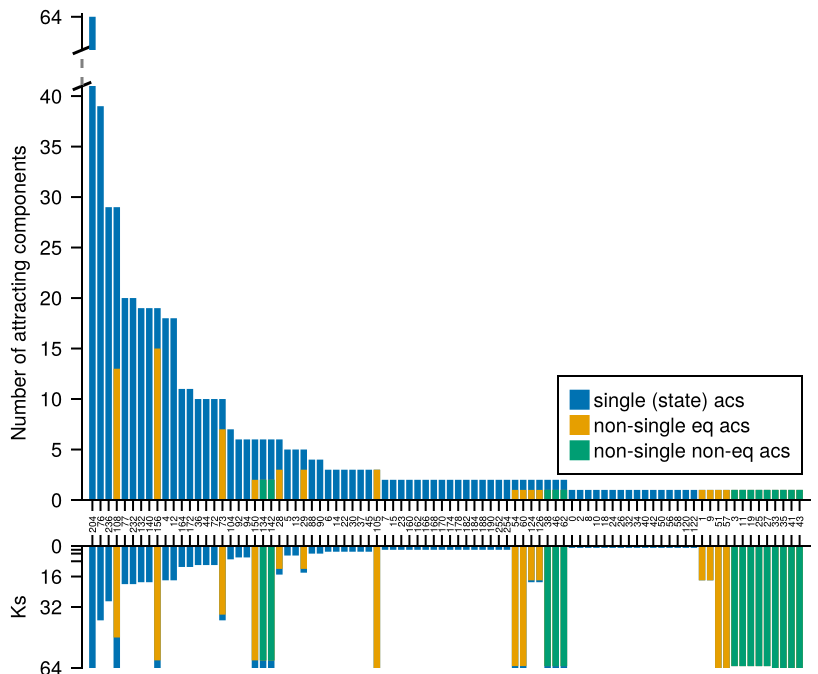

In [103]:
reduced = false
df = make_s1_data(6, reduced)
pos = 1:length(df.rs)

fig = Figure(;
    size=(double_col_width * 0.6, (double_col_width/golden_ratio) * 0.8),
    fontsize=10,
    figure_padding=4.0
)

################################################################################
# Do the numacs plot with a broken axis...
################################################################################
gl = GridLayout(fig[2,1])
ax = Axis(gl[2,1];
    xticks=(pos, string.(df.rs)),
    xticklabelsize=5.,
    xticklabelrotation=pi/2,
    xgridvisible=false,
    xautolimitmargin = (0.01, 0.01),
    # xlabel="Rule",
    ygridvisible=false,
)
ax2 = Axis(gl[1,1];
    xticksvisible=false,
    xticklabelsvisible=false,
    xgridvisible=false,
    xautolimitmargin=(0.01, 0.01),
    ygridvisible=false,
)
linkxaxes!(ax, ax2)

# plot data
for ax in [ax, ax2]
    barplot!(ax, pos, df.Nsingle .+ df.Neq .+ df.Nneq;
        color=Makie.wong_colors()[1],
        alpha=1.,
        label="single (state) acs",
    )
    barplot!(ax, pos, df.Neq .+ df.Nneq;
        color=Makie.wong_colors()[2],
        alpha=1.,
        label="non-single eq acs",
    )
    barplot!(ax, pos, df.Nneq;
        color=Makie.wong_colors()[3],
        alpha=1.,
        label="non-single non-eq acs",
    )
end

bp = 40
ylims!(ax, (0.0, bp+1))
ylims!(ax2, (bp, 66))
ax.yticks = 0:5:40
ax2.yticks = [64]

ax.ylabel = "Number of attracting components"
rowsize!(gl, 1, Relative(0.08))

ax2.bottomspinevisible = false
ax.topspinevisible = false
hidespines!(ax, :t, :r)
hidespines!(ax2, :t, :b, :r)

axislegend(ax;
    position=(1.01, 0.05),
    patchsize=(10., 10.),
    patchlabelgap=2,
    rowgap=1,
)

################################################################################
# Do the numstates in acs plots below
################################################################################
ax3 = Axis(fig[3,1];
    xaxisposition=:top,
    xticks=(1:length(df.rs), string.(df.rs)),
    xticklabelsvisible=false,
    xgridvisible=false,
    xautolimitmargin = (0.01, 0.01),
    # yticks=[0, 2, 4, 8, 16, 32, 64],
    yticks=([0, 2, 4, 8, 16, 32, 64], ["0", "", "", "", "16", "32", "64"]),
    yreversed=true,
    ygridvisible=false,
    yautolimitmargin=(0., 0.),
    # yscale=log2,
    ylabel="Ks",
)
hidespines!(ax3, :b, :r)

linkxaxes!(ax, ax3)

barplot!(ax3, pos, df.Ksingle .+ df.Keq .+ df.Kneq;
    color=Makie.wong_colors()[1],
    alpha=1.,
    label="single-state attractors",
)
barplot!(ax3, pos, df.Keq .+ df.Kneq;
    color=Makie.wong_colors()[2],
    alpha=1.,
    label="multistate equilibrium attractors",
)
barplot!(ax3, pos, df.Kneq;
    color=Makie.wong_colors()[3],
    alpha=1.,
    label="multistate non-equilibiurium attractors",
)

rowgap!(fig.layout, ax.xticklabelpad[])
rowsize!(fig.layout, 2, Relative(0.8))
rowsize!(fig.layout, 3, Relative(0.2))

################################################################################
# Draw broken axis decorations, has to be the last thing!
################################################################################
bl = ax.yaxis.attributes.endpoints[][2]
br = ax.elements[:yoppositeline][1][][2]
tl = ax2.yaxis.attributes.endpoints[][1]
tr = ax2.elements[:yoppositeline][1][][1]

angle_ = pi / 8
linelength = 10
# ps = Point2f[bl, br, tl, tr]
ps = Point2f[bl, tl]
segments = map(ps) do p
    a = p + Point2f(cos(angle_), sin(angle_)) * 0.5 * linelength
    b = p - Point2f(cos(angle_), sin(angle_)) * 0.5 * linelength
    (a, b)
end
linesegments!(fig.scene, segments, color=:black)
# linesegments!(fig.scene, [(bl, tl), (br, tr)], color=:gray, linestyle=:dash)
linesegments!(fig.scene, [(bl, tl)], color=:gray, linestyle=:dash)

################################################################################
# Draw and save the plot
################################################################################
fname = "../data/figures/numacs/v3_smaller.pdf"
save(fname, fig)
fig

## Large with space for plots hardcoded for 6

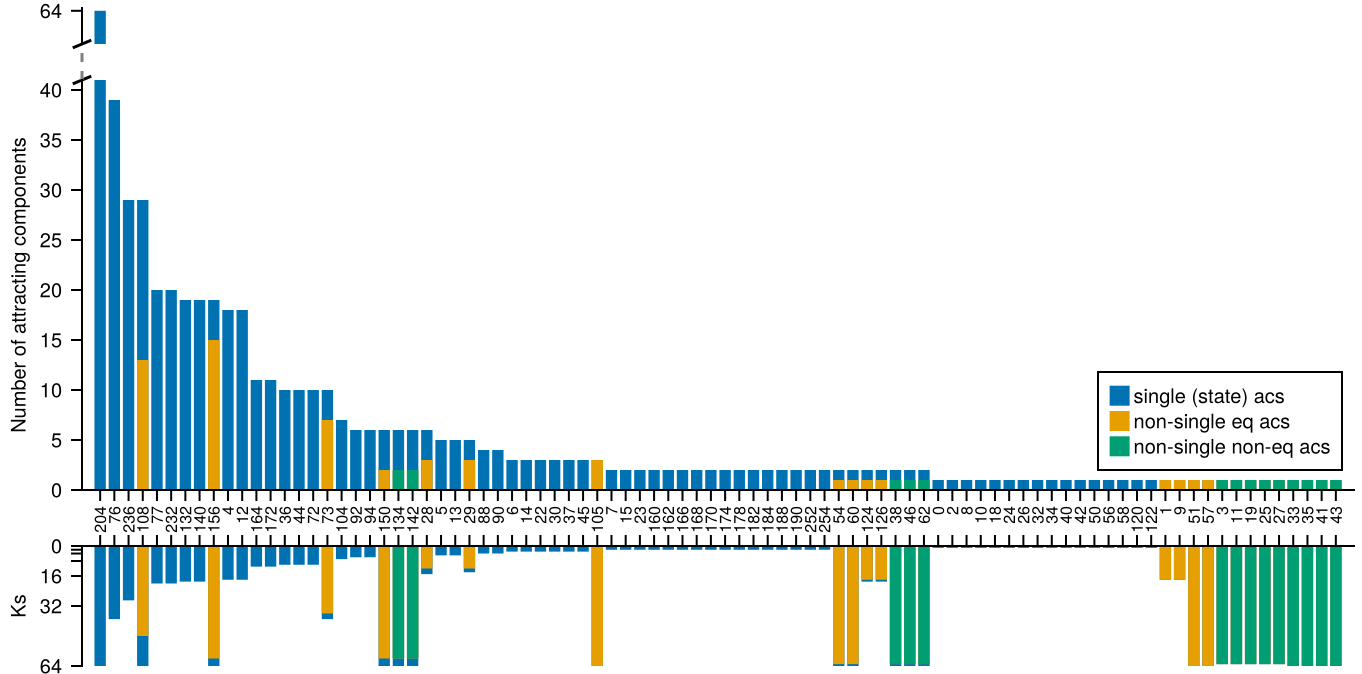

In [93]:
reduced = false
df = make_s1_data(6, reduced)
pos = 1:length(df.rs)

fig = Figure(;
    size=(double_col_width, (double_col_width/golden_ratio) * 0.8),
    fontsize=10,
    figure_padding=4.0
)

################################################################################
# Do the numacs plot with a broken axis...
################################################################################
gl = GridLayout(fig[1,1])
ax = Axis(gl[2,1];
    xticks=(pos, string.(df.rs)),
    xticklabelsize=8.,
    xticklabelrotation=pi/2,
    xgridvisible=false,
    xautolimitmargin = (0.01, 0.01),
    # xlabel="Rule",
    ygridvisible=false,
)
ax2 = Axis(gl[1,1];
    xticksvisible=false,
    xticklabelsvisible=false,
    xgridvisible=false,
    xautolimitmargin=(0.01, 0.01),
    ygridvisible=false,
)
linkxaxes!(ax, ax2)

# plot data
for ax in [ax, ax2]
    barplot!(ax, pos, df.Nsingle .+ df.Neq .+ df.Nneq;
        color=Makie.wong_colors()[1],
        alpha=1.,
        label="single (state) acs",
    )
    barplot!(ax, pos, df.Neq .+ df.Nneq;
        color=Makie.wong_colors()[2],
        alpha=1.,
        label="non-single eq acs",
    )
    barplot!(ax, pos, df.Nneq;
        color=Makie.wong_colors()[3],
        alpha=1.,
        label="non-single non-eq acs",
    )
end

bp = 40
ylims!(ax, (0.0, bp+1))
ylims!(ax2, (bp, 66))
ax.yticks = 0:5:40
ax2.yticks = [64]

ax.ylabel = "Number of attracting components"
rowsize!(gl, 1, Relative(0.08))

ax2.bottomspinevisible = false
ax.topspinevisible = false
hidespines!(ax, :t, :r)
hidespines!(ax2, :t, :b, :r)

axislegend(ax;
    position=(1., 0.03),
    patchsize=(10., 10.),
    patchlabelgap=2,
    rowgap=1,
)

################################################################################
# Do the numstates in acs plots below
################################################################################
ax3 = Axis(fig[2,1];
    xaxisposition=:top,
    xticks=(1:length(df.rs), string.(df.rs)),
    xticklabelsvisible=false,
    xgridvisible=false,
    xautolimitmargin = (0.01, 0.01),
    # yticks=[0, 2, 4, 8, 16, 32, 64],
    yticks=([0, 2, 4, 8, 16, 32, 64], ["0", "", "", "", "16", "32", "64"]),
    yreversed=true,
    ygridvisible=false,
    yautolimitmargin=(0., 0.),
    # yscale=log2,
    ylabel="Ks",
)
hidespines!(ax3, :b, :r)

linkxaxes!(ax, ax3)

barplot!(ax3, pos, df.Ksingle .+ df.Keq .+ df.Kneq;
    color=Makie.wong_colors()[1],
    alpha=1.,
    label="single-state attractors",
)
barplot!(ax3, pos, df.Keq .+ df.Kneq;
    color=Makie.wong_colors()[2],
    alpha=1.,
    label="multistate equilibrium attractors",
)
barplot!(ax3, pos, df.Kneq;
    color=Makie.wong_colors()[3],
    alpha=1.,
    label="multistate non-equilibiurium attractors",
)

rowgap!(fig.layout, ax.xticklabelpad[])
rowsize!(fig.layout, 2, Relative(0.2))

################################################################################
# Draw broken axis decorations, has to be the last thing!
################################################################################
bl = ax.yaxis.attributes.endpoints[][2]
br = ax.elements[:yoppositeline][1][][2]
tl = ax2.yaxis.attributes.endpoints[][1]
tr = ax2.elements[:yoppositeline][1][][1]

angle_ = pi / 8
linelength = 10
# ps = Point2f[bl, br, tl, tr]
ps = Point2f[bl, tl]
segments = map(ps) do p
    a = p + Point2f(cos(angle_), sin(angle_)) * 0.5 * linelength
    b = p - Point2f(cos(angle_), sin(angle_)) * 0.5 * linelength
    (a, b)
end
linesegments!(fig.scene, segments, color=:black)
# linesegments!(fig.scene, [(bl, tl), (br, tr)], color=:gray, linestyle=:dash)
linesegments!(fig.scene, [(bl, tl)], color=:gray, linestyle=:dash)

################################################################################
# Draw and save the plot
################################################################################
fname = "../data/figures/numacs/v3_large.pdf"
save(fname, fig)
fig

## Standalone

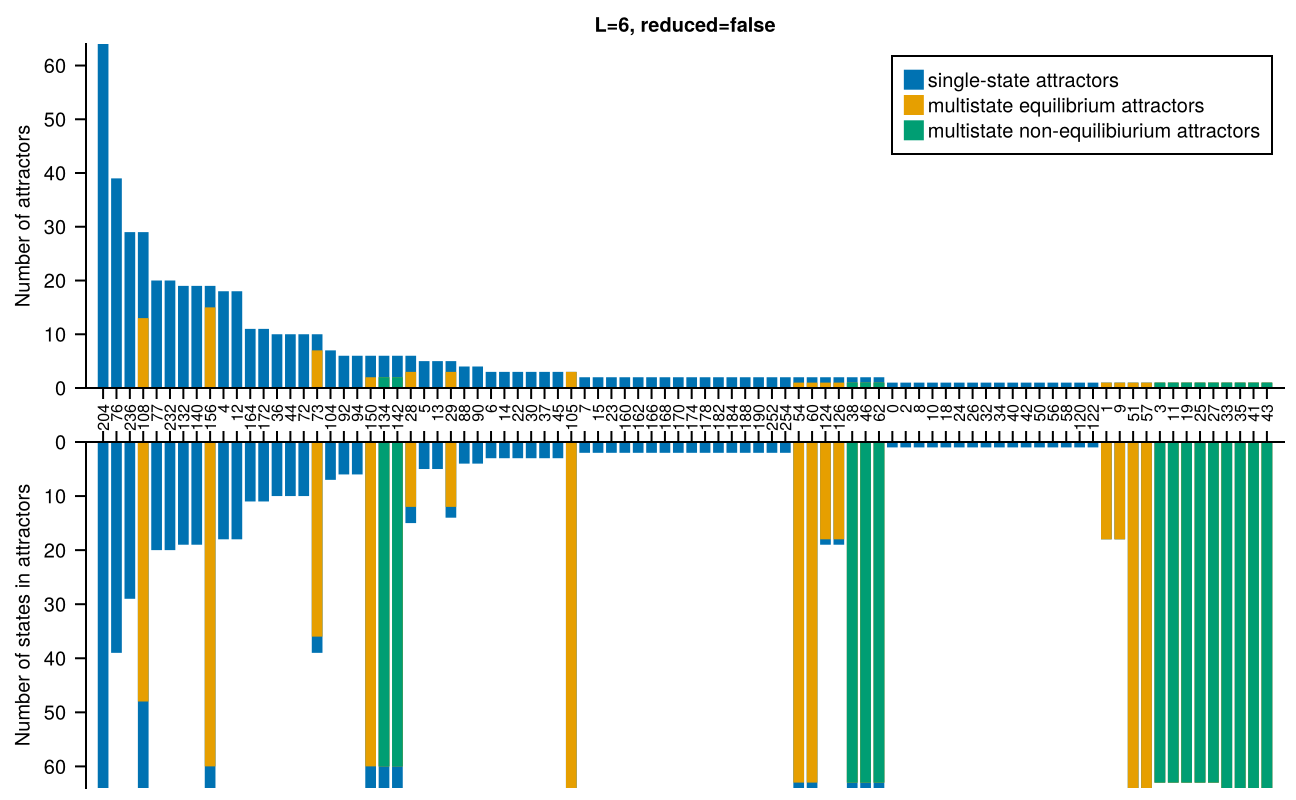

In [150]:
L = 6
reduced = false
df = make_s1_data(L, reduced)
pos = 1:length(df.rs)

fig = Figure(;
    size=(double_col_width, double_col_width/golden_ratio),
    fontsize=10,
    figure_padding=6.0
)

################################################################################
# Do Ns plot
################################################################################
ax1 = Axis(fig[1,1];
    title="L=$L, reduced=$reduced",
    xticks=(1:length(df.rs), string.(df.rs)),
    xticklabelsize=8.,
    xticklabelrotation=pi/2,
    xgridvisible=false,
    xautolimitmargin = (0.01, 0.01),
    # xlabel="Rule",
    ygridvisible=false,
    yautolimitmargin=(0., 0.),
    # yscale=log2,
    ylabel="Number of attractors",
)
hidespines!(ax1, :t, :r)

# plot data
barplot!(ax1, pos, df.Nsingle .+ df.Neq .+ df.Nneq;
    color=Makie.wong_colors()[1],
    alpha=1.,
    label="single-state attractors",
)
barplot!(ax1, pos, df.Neq .+ df.Nneq;
    color=Makie.wong_colors()[2],
    alpha=1.,
    label="multistate equilibrium attractors",
)
barplot!(ax1, pos, df.Nneq;
    color=Makie.wong_colors()[3],
    alpha=1.,
    label="multistate non-equilibiurium attractors",
)

axislegend(ax1;
    # position=(1., 0.03),
    patchsize=(10., 10.),
    patchlabelgap=2,
    rowgap=1,
)

################################################################################
# Do Ks plot
################################################################################
ax2 = Axis(fig[2,1];
    xaxisposition=:top,
    xticks=(1:length(df.rs), string.(df.rs)),
    xticklabelsvisible=false,
    xgridvisible=false,
    xautolimitmargin = (0.01, 0.01),
    yreversed=true,
    ygridvisible=false,
    yautolimitmargin=(0., 0.),
    # yscale=log2,
    ylabel="Number of states in attractors",
)
hidespines!(ax2, :b, :r)

linkxaxes!(ax1, ax2)

barplot!(ax2, pos, df.Ksingle .+ df.Keq .+ df.Kneq;
    color=Makie.wong_colors()[1],
    alpha=1.,
    label="single-state attractors",
)
barplot!(ax2, pos, df.Keq .+ df.Kneq;
    color=Makie.wong_colors()[2],
    alpha=1.,
    label="multistate equilibrium attractors",
)
barplot!(ax2, pos, df.Kneq;
    color=Makie.wong_colors()[3],
    alpha=1.,
    label="multistate non-equilibiurium attractors",
)

################################################################################
# Adjust the layout
################################################################################

rowgap!(fig.layout, ax1.xticklabelpad[])

fname = "../data/figures/numacs/v2_$L"*(reduced ? "r" : "f")*".pdf"
save(fname, fig)
fig

In [ ]:
f = Figure()
ax = Axis(f[1,1])

barplot!(ax2, pos, df.Ksingle .+ df.Keq .+ df.Kneq;
    color=Makie.wong_colors()[1],
    alpha=1.,
    label="single-state attractors",
)
barplot!(ax2, pos, df.Keq .+ df.Kneq;
    color=Makie.wong_colors()[2],
    alpha=1.,
    label="multistate equilibrium attractors",
)
barplot!(ax2, pos, df.Kneq;
    color=Makie.wong_colors()[3],
    alpha=1.,
    label="multistate non-equilibiurium attractors",
)

f

# Main fig 2

## Figure 2 V2 - harcoded for L=6

In [4]:
includet("../scripts/ned_ca_s1_stats.jl")

In [5]:
L = 6
rs = ca_ucodes_f1()
# rs = 0:255
reduced=false
# reduced=true
mas = MolAut.(L, rs;
    reduced
)

numenz = ca_numenzymes.(rs)
numacs = [length(attracting_components(ma.mg)) for ma in mas]
Nac = []
Nsingle = []
Neq = []
Nneq = []
for ma in mas
    acs = attracting_components(ma.mg)
    push!(Nac, length(acs))
    acis_single, acis_eq, acis_neq, _, _ = classify_acs_s1_stats(ma.mg, acs)
    push!(Nsingle, length(acis_single))
    push!(Neq, length(acis_eq))
    push!(Nneq, length(acis_neq))
end

sp = sortperm(collect(zip(.- Nac, .- Nsingle, .- Neq, rs)))

pos = 1:length(rs)
rs = rs[sp]
numacs = numacs[sp]
numenz = numenz[sp]
Nac = Nac[sp]
Nsingle = Nsingle[sp]
Neq = Neq[sp]
Nneq = Nneq[sp]
nothing

┌ Warning: Note: adding edges with a zero weight to this graph type has no effect.
└ @ SimpleWeightedGraphs ~/.julia/packages/SimpleWeightedGraphs/Ab8wv/src/simpleweighteddigraph.jl:170


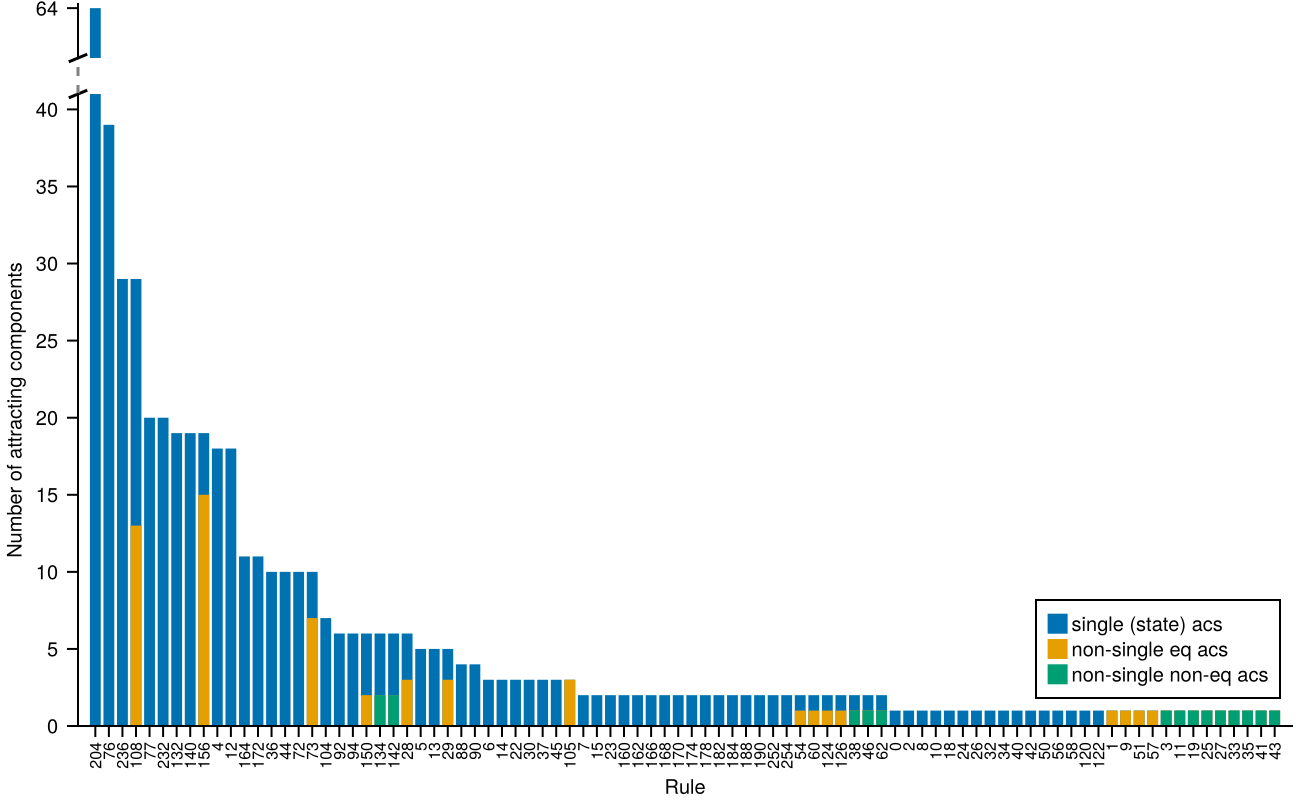

In [22]:
fig = Figure(;
    size=(double_col_width, double_col_width/golden_ratio),
    fontsize=10,
    figure_padding=2.0
)
# prep axes
gl = GridLayout(fig[1,1])
ax = Axis(gl[2,1];
    xticks=(1:length(rs), string.(rs)),
    xticklabelsize=8.,
    xticklabelrotation=pi/2,
    xgridvisible=false,
    xautolimitmargin = (0.01, 0.01),
    xlabel="Rule",
    ygridvisible=false,
)
ax2 = Axis(gl[1,1];
    xticksvisible=false,
    xticklabelsvisible=false,
    xgridvisible=false,
    xautolimitmargin=(0.01, 0.01),
    ygridvisible=false,
)
linkxaxes!(ax, ax2)

# plot data
for ax in [ax, ax2]
    barplot!(ax, pos, Nsingle .+ Neq .+ Nneq;
        color=Makie.wong_colors()[1],
        alpha=1.,
        label="single (state) acs",
    )
    barplot!(ax, pos, Neq .+ Nneq;
        color=Makie.wong_colors()[2],
        alpha=1.,
        label="non-single eq acs",
    )
    barplot!(ax, pos, Nneq;
        color=Makie.wong_colors()[3],
        alpha=1.,
        label="non-single non-eq acs",
    )
end

if reduced
    bp = 8
    ylims!(ax, (0.0, bp+0.5))
    ylims!(ax2, (bp, 15))
    # ax.yticks = [0, 5, 10, 15, 20]
    ax2.yticks = [9, 12, 15]
else
    bp = 40
    ylims!(ax, (0.0, bp+1))
    ylims!(ax2, (bp, 66))
    ax.yticks = 0:5:40
    ax2.yticks = [64]
end

# labels
# Label(gl[1:2,1,Left()], "Number of attracting components";
#     rotation=pi/2,
#     padding=-10000
# )
ax.ylabel = "Number of attracting components"
# colsize!(gl, 1, Fixed(0.))
rowsize!(gl, 1, Relative(0.08))

# add the axis break
ax2.bottomspinevisible = false
ax.topspinevisible = false

# hlines!(ax2, bp; color=:gray, linestyle=:dash)
# hlines!(ax, bp; color=:gray, linestyle=:dash)

bl = ax.yaxis.attributes.endpoints[][2]
br = ax.elements[:yoppositeline][1][][2]
tl = ax2.yaxis.attributes.endpoints[][1]
tr = ax2.elements[:yoppositeline][1][][1]

angle_ = pi / 8
linelength = 10
# ps = Point2f[bl, br, tl, tr]
ps = Point2f[bl, tl]
segments = map(ps) do p
    a = p + Point2f(cos(angle_), sin(angle_)) * 0.5 * linelength
    b = p - Point2f(cos(angle_), sin(angle_)) * 0.5 * linelength
    (a, b)
end
linesegments!(fig.scene, segments, color=:black)
# linesegments!(fig.scene, [(bl, tl), (br, tr)], color=:gray, linestyle=:dash)
linesegments!(fig.scene, [(bl, tl)], color=:gray, linestyle=:dash)

# remove framing
hidespines!(ax, :t, :r)
hidespines!(ax2, :t, :b, :r)

axislegend(ax;
    position=(1., 0.03),
    patchsize=(10., 10.),
    patchlabelgap=2,
    rowgap=1,
)

# temp title (will be caption)
# ax2.title = (reduced ? "Reduced" : "Full") * " description with L=$L"
# ax2.title = L"KAKA=2"

fname = "../data/figures/numacs/stackedbars_L$L"*(reduced ? "r" : "f")*".pdf"
save(fname, fig)
fig

## Figure 2 V2 - harcoded for L=5

In [113]:
includet("../scripts/ned_ca_s1_stats.jl")

In [114]:
L = 5
rs = ca_ucodes_f1()
# rs = 0:255
reduced=false
# reduced=true
mas = MolAut.(L, rs;
    reduced
)

numenz = ca_numenzymes.(rs)
numacs = [length(attracting_components(ma.mg)) for ma in mas]
Nac = []
Nsingle = []
Neq = []
Nneq = []
for ma in mas
    acs = attracting_components(ma.mg)
    push!(Nac, length(acs))
    acis_single, acis_eq, acis_neq, _, _ = classify_acs_s1_stats(ma.mg, acs)
    push!(Nsingle, length(acis_single))
    push!(Neq, length(acis_eq))
    push!(Nneq, length(acis_neq))
end

sp = sortperm(collect(zip(.- Nac, .- Nsingle, .- Neq, rs)))

pos = 1:length(rs)
rs = rs[sp]
numacs = numacs[sp]
numenz = numenz[sp]
Nac = Nac[sp]
Nsingle = Nsingle[sp]
Neq = Neq[sp]
Nneq = Nneq[sp]
nothing

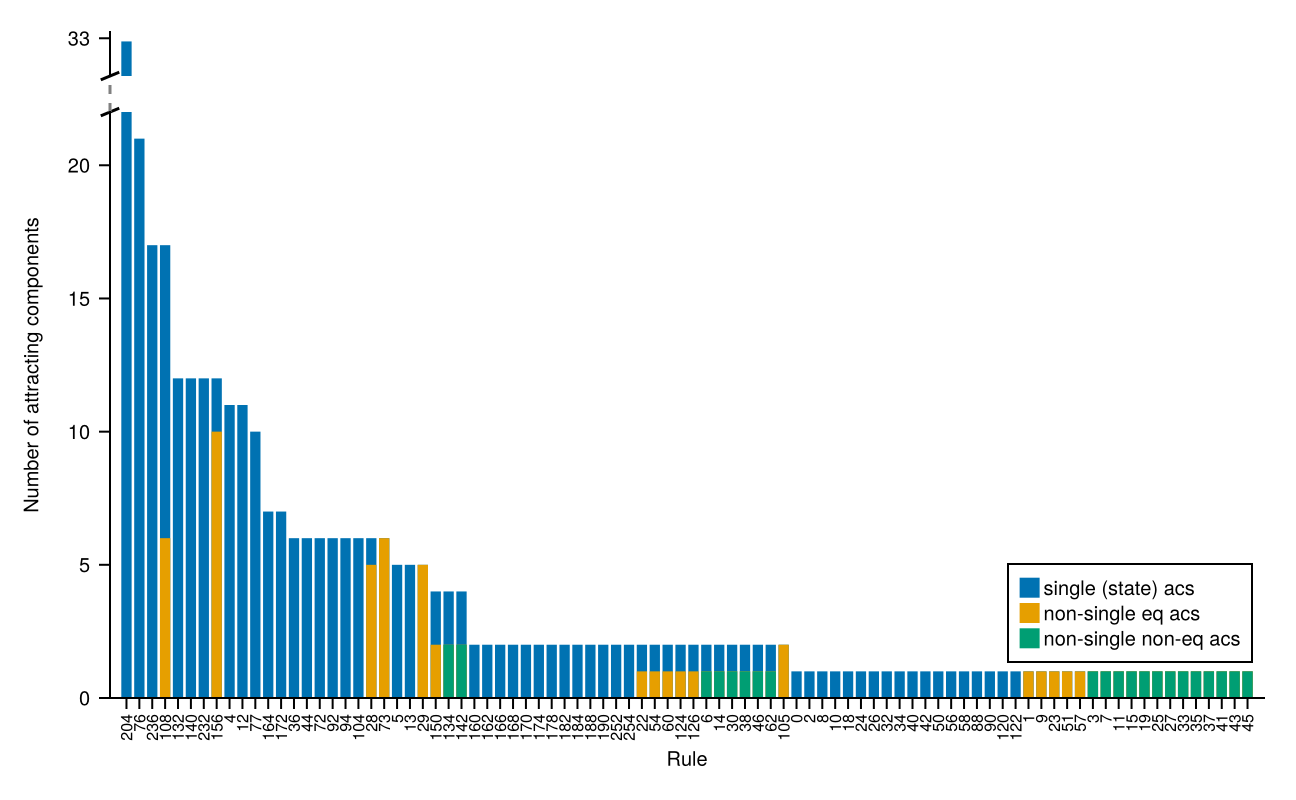

In [119]:
fig = Figure(;
    size=(double_col_width, double_col_width/golden_ratio),
    fontsize=10
)
# prep axes
gl = GridLayout(fig[1,1])
ax = Axis(gl[2,2];
    xticks=(1:length(rs), string.(rs)),
    xticklabelsize=8.,
    xticklabelrotation=pi/2,
    xgridvisible=false,
    xautolimitmargin = (0.01, 0.01),
    xlabel="Rule",
    ygridvisible=false,
)
ax2 = Axis(gl[1,2];
    xticksvisible=false,
    xticklabelsvisible=false,
    xgridvisible=false,
    xautolimitmargin=(0.01, 0.01),
    ygridvisible=false,
)
linkxaxes!(ax, ax2)

# plot data
for ax in [ax, ax2]
    barplot!(ax, pos, Nsingle .+ Neq .+ Nneq;
        color=Makie.wong_colors()[1],
        alpha=1.,
        label="single (state) acs",
    )
    barplot!(ax, pos, Neq .+ Nneq;
        color=Makie.wong_colors()[2],
        alpha=1.,
        label="non-single eq acs",
    )
    barplot!(ax, pos, Nneq;
        color=Makie.wong_colors()[3],
        alpha=1.,
        label="non-single non-eq acs",
    )
end

bp = 21
ylims!(ax, (0.0, bp+1))
ylims!(ax2, (bp, 35))
ax.yticks = 0:5:20
ax2.yticks = [33]

# labels
Label(gl[1:2,1,Left()], "Number of attracting components";
    rotation=pi/2,
    padding=-10000
)
colsize!(gl, 1, Fixed(0.))
rowsize!(gl, 1, Relative(0.07))

# add the axis break
ax2.bottomspinevisible = false
ax.topspinevisible = false

# hlines!(ax2, bp; color=:gray, linestyle=:dash)
# hlines!(ax, bp; color=:gray, linestyle=:dash)

bl = ax.yaxis.attributes.endpoints[][2]
br = ax.elements[:yoppositeline][1][][2]
tl = ax2.yaxis.attributes.endpoints[][1]
tr = ax2.elements[:yoppositeline][1][][1]

angle_ = pi / 8
linelength = 10
# ps = Point2f[bl, br, tl, tr]
ps = Point2f[bl, tl]
segments = map(ps) do p
    a = p + Point2f(cos(angle_), sin(angle_)) * 0.5 * linelength
    b = p - Point2f(cos(angle_), sin(angle_)) * 0.5 * linelength
    (a, b)
end
linesegments!(fig.scene, segments, color=:black)
# linesegments!(fig.scene, [(bl, tl), (br, tr)], color=:gray, linestyle=:dash)
linesegments!(fig.scene, [(bl, tl)], color=:gray, linestyle=:dash)

# remove framing
hidespines!(ax, :t, :r)
hidespines!(ax2, :t, :b, :r)

axislegend(ax;
    position=(1., 0.05),
    patchsize=(10., 10.),
    patchlabelgap=2,
    rowgap=1,
)

# temp title (will be caption)
# ax2.title = (reduced ? "Reduced" : "Full") * " description with L=$L"
# ax2.title = L"KAKA=2"

fname = "../data/fig2/stackedbars_L$L"*(reduced ? "r" : "f")*".pdf"
save(fname, fig)
fig

## Figure 2 V1.5, for testing

In [575]:
includet("../scripts/ned_ca_s1_stats.jl")

In [576]:
function prep_p1(rules;
        size=(double_col_width, double_col_width/golden_ratio),
        kwargs...
    )
    fig = Figure(; size)
    ax = Axis(fig[1,1];
        xticks = (1:length(rs), string.(rs)),
        xticklabelsize=8.,
        xticklabelrotation=pi/2,
        xgridvisible=false,
        xautolimitmargin = (0.01, 0.01),
        xlabel="Rule",
        kwargs...
    )

    fig, ax
end

prep_p1 (generic function with 1 method)

In [586]:
L = 7
rs = ca_ucodes_f1()
# rs = 0:255
mas = MolAut.(L, rs;
    # reduced=true
    reduced=false
)

numenz = ca_numenzymes.(rs)
numacs = [length(attracting_components(ma.mg)) for ma in mas]
Nac = []
Nsingle = []
Neq = []
Nneq = []
for ma in mas
    acs = attracting_components(ma.mg)
    push!(Nac, length(acs))
    acis_single, acis_eq, acis_neq, _, _ = classify_acs_s1_stats(ma.mg, acs)
    push!(Nsingle, length(acis_single))
    push!(Neq, length(acis_eq))
    push!(Nneq, length(acis_neq))
end

sp = sortperm(collect(zip(.- Nac, .- Nsingle, .- Neq)))

pos = 1:length(rs)
rs = rs[sp]
numacs = numacs[sp]
numenz = numenz[sp]
Nac = Nac[sp]
Nsingle = Nsingle[sp]
Neq = Neq[sp]
Nneq = Nneq[sp]
nothing

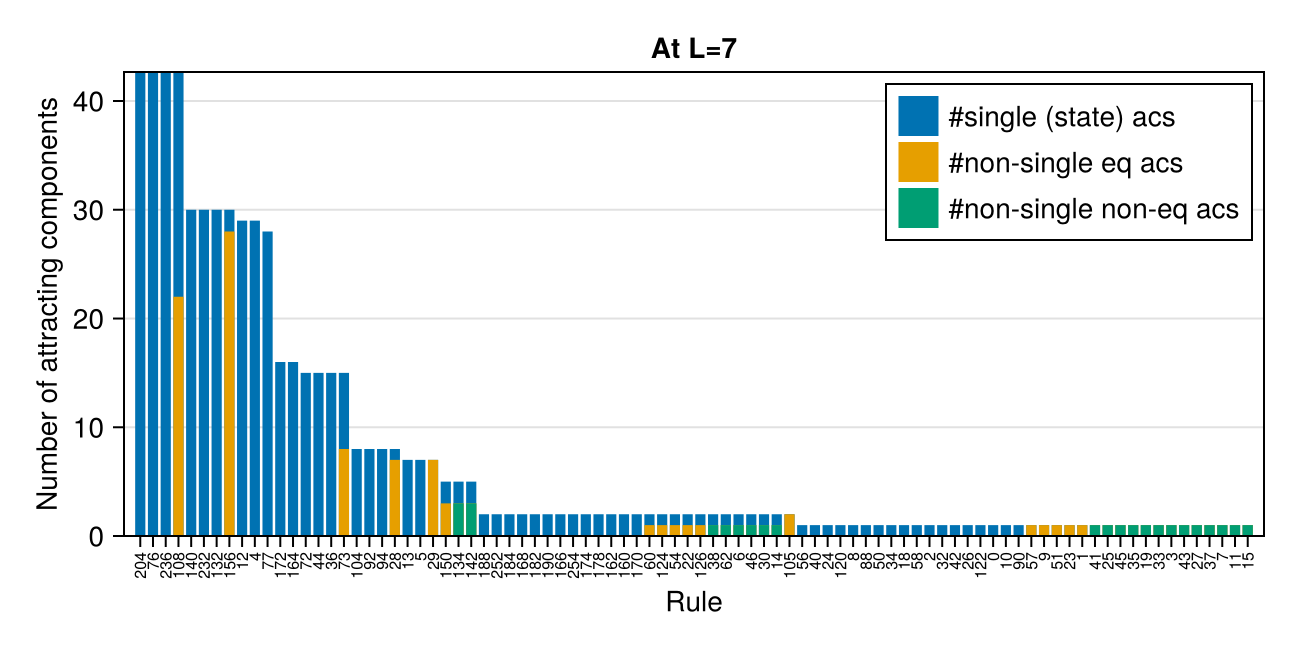

In [587]:
f, ax = prep_p1(rs;
    size=(double_col_width, double_col_width/2),
    # yscale=log10
)
ax.title = "At L=$L"
ax.ylabel = "Number of attracting components"
barplot!(ax, pos, Nsingle .+ Neq .+ Nneq;
    color=Makie.wong_colors()[1],
    alpha=1.,
    label="#single (state) acs",
)
barplot!(ax, pos, Neq .+ Nneq;
    color=Makie.wong_colors()[2],
    alpha=1.,
    label="#non-single eq acs",
)
barplot!(ax, pos, Nneq;
    color=Makie.wong_colors()[3],
    alpha=1.,
    label="#non-single non-eq acs",
)
axislegend(ax)

ylims!(ax, (0.0, 2^L / 3))

save("stackedbars.pdf", f)
f

## Figure 2 V1

In [163]:
includet("../scripts/ned_ca_s1_stats.jl")

In [386]:
function prep_p1(rules;
        size=(double_col_width, double_col_width/golden_ratio),
        kwargs...
    )
    fig = Figure(; size)
    ax = Axis(fig[1,1];
        xticks = (1:length(rs), string.(rs)),
        xticklabelsize=8.,
        xticklabelrotation=pi/2,
        xgridvisible=false,
        xautolimitmargin = (0.01, 0.01),
        xlabel="Rule",
        kwargs...
    )

    fig, ax
end

prep_p1 (generic function with 1 method)

In [395]:
L = 6
rs = ca_ucodes_f1()
# rs = 0:255
mas = MolAut.(L, rs;
    reduced=true
    # reduced=false
)

numenz = ca_numenzymes.(rs)
numacs = [length(attracting_components(ma.mg)) for ma in mas]
Nac = []
Nsingle = []
Neq = []
Nneq = []
for ma in mas
    acs = attracting_components(ma.mg)
    push!(Nac, length(acs))
    acis_single, acis_eq, acis_neq, _, _ = classify_acs_s1_stats(ma.mg, acs)
    push!(Nsingle, length(acis_single))
    push!(Neq, length(acis_eq))
    push!(Nneq, length(acis_neq))
end

sp = sortperm(collect(zip(.- Nac, .- Nsingle, .- Neq)))

pos = 1:length(rs)
rs = rs[sp]
numacs = numacs[sp]
numenz = numenz[sp]
Nac = Nac[sp]
Nsingle = Nsingle[sp]
Neq = Neq[sp]
Nneq = Nneq[sp]
nothing

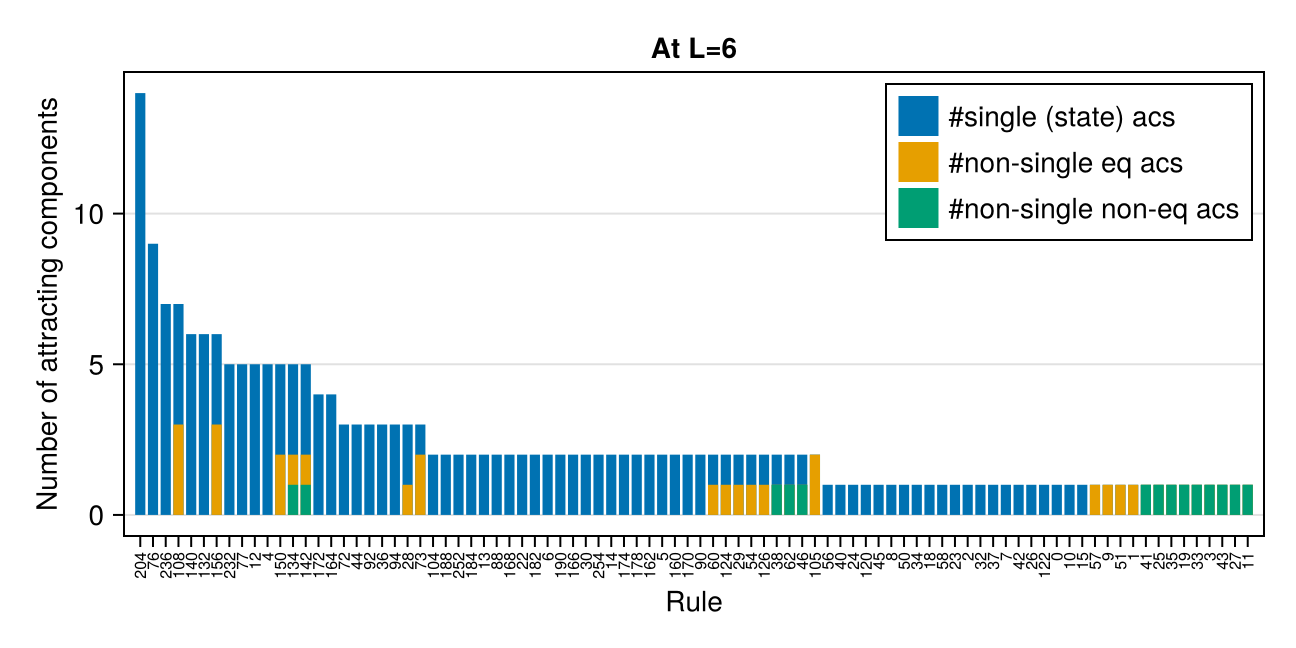

In [396]:
f, ax = prep_p1(rs;
    size=(double_col_width, double_col_width/2),
    # yscale=log10
)
ax.title = "At L=$L"
ax.ylabel = "Number of attracting components"
barplot!(ax, pos, Nsingle .+ Neq .+ Nneq;
    color=Makie.wong_colors()[1],
    alpha=1.,
    label="#single (state) acs",
)
barplot!(ax, pos, Neq .+ Nneq;
    color=Makie.wong_colors()[2],
    alpha=1.,
    label="#non-single eq acs",
)
barplot!(ax, pos, Nneq;
    color=Makie.wong_colors()[3],
    alpha=1.,
    label="#non-single non-eq acs",
)
axislegend(ax)

# ylims!(ax, (0.0, 40))

save("stackedbars.pdf", f)
f

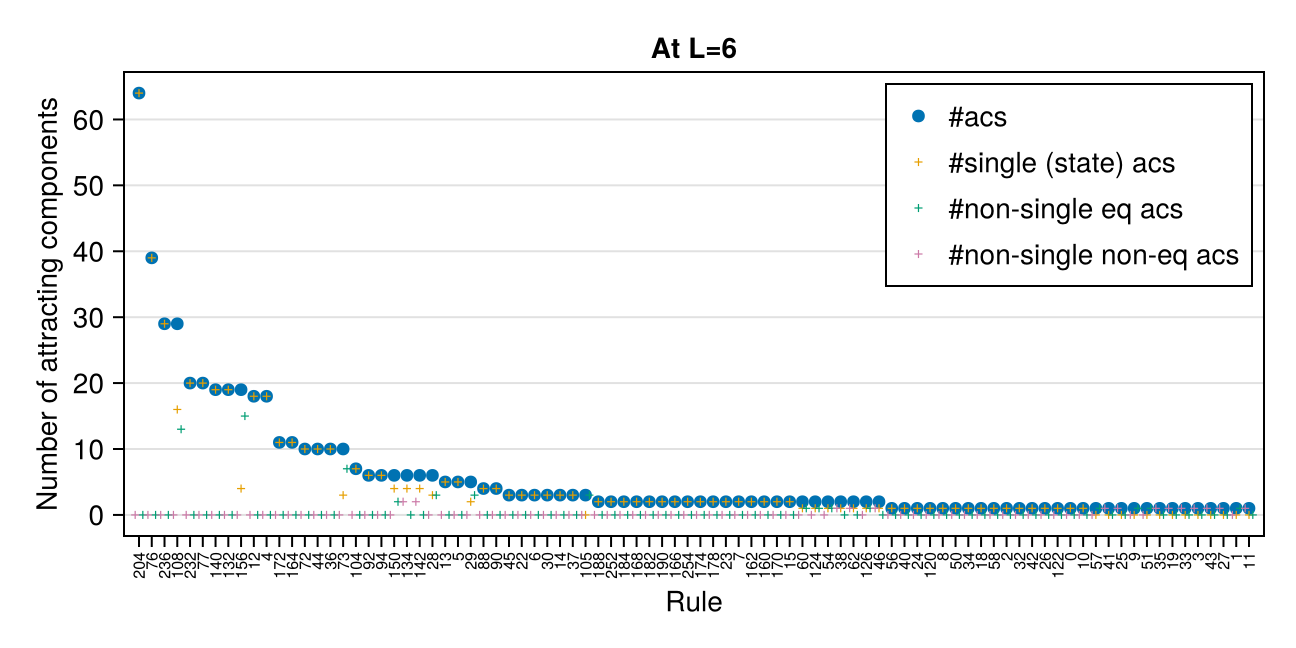

In [384]:
f, ax = prep_p1(rs;
    size=(double_col_width, double_col_width/2),
    # yscale=log10
)
ax.title = "At L=$L"
ax.ylabel = "Number of attracting components"
sc = scatter!(ax, pos, Nac;
    label="#acs"
    # color=numenz,
    # colormap=Categorical(:tab20)
    # marker='+'
)
sc = scatter!(ax, pos, Nsingle;
    label="#single (state) acs",
    marker='+'
)
sc = scatter!(ax, pos .+ 0.3, Neq;
    label="#non-single eq acs",
    marker='+'
)
sc = scatter!(ax, pos .- 0.3, Nneq;
    label="#non-single non-eq acs",
    marker='+'
)

axislegend(ax)
# Colorbar(f[1,2], sc)

save("scatter.pdf", f)
f

In [80]:
ax.limits

Observable{Any}((nothing, nothing))
    0 => (::Makie.var"#1751#1782")(::Any) @ Makie ~/.julia/packages/Makie/FUAHr/src/makielayout/blocks/axis.jl:499


In [26]:
numacs[sp]

88-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 4
 4
 5
 5
 5
 5
 5
 5
 5
 6
 7
 8

In [4]:
typeof(mg)

LoadError: UndefVarError: `mg` not defined

# Looking for patterns in non-eq ac rules

In [13]:
hcat(cacode_to_Ks(62)...)

2×4 Matrix{Int64}:
 0  1  0  0
 1  1  1  1

In [14]:
cacode_to_Ks(62)

([0 1; 1 1], [0 0; 1 1])

In [18]:
for (r, xx) in zip(rs, Nneq)
    if xx != 0
        print("r=$r")
        display(hcat(cacode_to_Ks(r)...))
    end
end

r=134

2×4 Matrix{Int64}:
 0  1  0  1
 0  0  1  0

r=142

2×4 Matrix{Int64}:
 0  1  0  0
 0  0  1  0

r=38

2×4 Matrix{Int64}:
 0  1  0  1
 0  1  1  1

r=46

2×4 Matrix{Int64}:
 0  1  0  0
 0  1  1  1

r=62

2×4 Matrix{Int64}:
 0  1  0  0
 1  1  1  1

r=3

2×4 Matrix{Int64}:
 1  1  1  1
 0  0  1  1

r=11

2×4 Matrix{Int64}:
 1  1  1  0
 0  0  1  1

r=19

2×4 Matrix{Int64}:
 1  1  1  1
 1  0  1  1

r=25

2×4 Matrix{Int64}:
 1  0  1  0
 1  0  1  1

r=27

2×4 Matrix{Int64}:
 1  1  1  0
 1  0  1  1

r=33

2×4 Matrix{Int64}:
 1  0  1  1
 0  1  1  1

r=35

2×4 Matrix{Int64}:
 1  1  1  1
 0  1  1  1

r=41

2×4 Matrix{Int64}:
 1  0  1  0
 0  1  1  1

r=43

2×4 Matrix{Int64}:
 1  1  1  0
 0  1  1  1

# Looking at #states in acs instead

In [91]:
includet("../scripts/ned_ca_s1_stats.jl")

In [103]:
function prep_p1(rules;
        size=(double_col_width, double_col_width/golden_ratio),
        fontsize=10,
        kwargs...
    )
    fig = Figure(; size, fontsize)
    ax = Axis(fig[1,1];
        xticks = (1:length(rs), string.(rs)),
        xticklabelsize=8.,
        xticklabelrotation=pi/2,
        xgridvisible=false,
        xautolimitmargin = (0.01, 0.01),
        xlabel="Rule",
        kwargs...
    )

    fig, ax
end

prep_p1 (generic function with 1 method)

In [108]:
L = 6
rs = ca_ucodes_f1()
# rs = 0:255
# reduced=false
reduced=true
mas = MolAut.(L, rs;
    reduced
)

numenz = ca_numenzymes.(rs)
numacs = [length(attracting_components(ma.mg)) for ma in mas]
Nac = []
Nsingle = []
Neq = []
Nneq = []
Kac = []
Ksingle = []
Keq = []
Kneq = []
for ma in mas
    acs = attracting_components(ma.mg)
    acis_single, acis_eq, acis_neq, _, _ = classify_acs_s1_stats(ma.mg, acs)
    
    push!(Nac, length(acs))
    push!(Nsingle, length(acis_single))
    push!(Neq, length(acis_eq))
    push!(Nneq, length(acis_neq))

    Ksingle_ = 0
    for aci in acis_single
        Ksingle_ += length(acs[aci])
    end
    Keq_ = 0
    for aci in acis_eq
        Keq_ += length(acs[aci])
    end
    Kneq_ = 0
    for aci in acis_neq
        Kneq_ += length(acs[aci])
    end
    push!(Kac, sum(length, acs))
    push!(Ksingle, Ksingle_)
    push!(Keq, Keq_)
    push!(Kneq, Kneq_)
end

sp = sortperm(collect(zip(.- Kac, .- Ksingle, .- Keq, rs)))

pos = 1:length(rs)
rs = rs[sp]
numacs = numacs[sp]
numenz = numenz[sp]
Kac = Kac[sp]
Ksingle = Ksingle[sp]
Keq = Keq[sp]
Kneq = Kneq[sp]
nothing

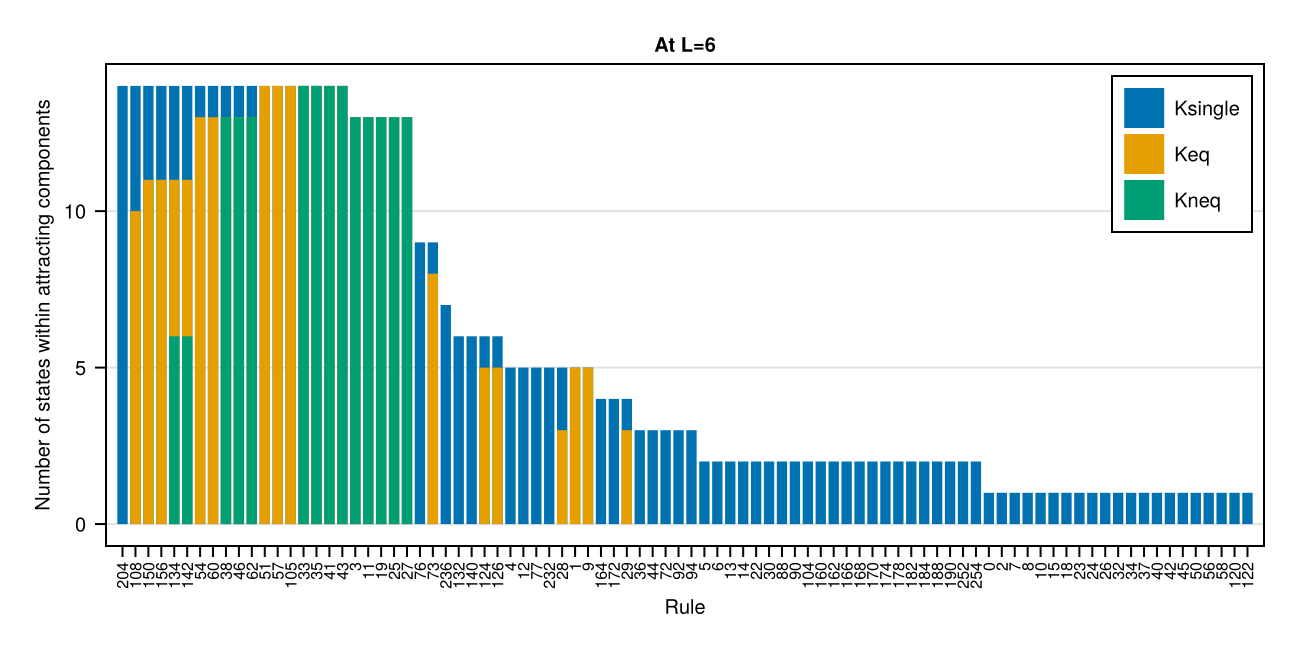

In [109]:
f, ax = prep_p1(rs;
    size=(double_col_width, double_col_width/2),
    # yscale=log10
)
ax.title = "At L=$L"
ax.ylabel = "Number of states within attracting components"
barplot!(ax, pos, Ksingle .+ Keq .+ Kneq;
    color=Makie.wong_colors()[1],
    alpha=1.,
    label="Ksingle",
)
barplot!(ax, pos, Keq .+ Kneq;
    color=Makie.wong_colors()[2],
    alpha=1.,
    label="Keq",
)
barplot!(ax, pos, Kneq;
    color=Makie.wong_colors()[3],
    alpha=1.,
    label="Kneq",
)
axislegend(ax)

# ylims!(ax, (0.0, 40))

fname = "../data/figures/numacs/Ks"*(reduced ? "r" : "f")*".pdf"
save(fname, f)
f

# Bits and bobs

In [3]:
GC.gc()
empty!(Out)
GC.gc()